# 1. Import Dependencies

In [1]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
import pandas as pd
import random
from tqdm import tqdm
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random
from torch.utils.data import DataLoader,random_split

# 2. Download Data and Generate dataloader

In [3]:
from google.colab import drive
import os

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
!export PYTHONPATH=$PYTHONPATH:"/content/gdrive/MyDrive/CS7180"

In [7]:
%cd /content/gdrive/MyDrive/CS7180

/content/gdrive/MyDrive/CS7180


In [8]:
!git clone https://github.com/gourav10/autoencoder_embedding.git

fatal: destination path 'autoencoder_embedding' already exists and is not an empty directory.


In [9]:
%cd /content/gdrive/MyDrive/CS7180/autoencoder_embedding

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [10]:
import os
import config
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/'
os.makedirs(config.DATA_DIR,exist_ok=True)

In [11]:
# load the training and test datasets
train_data = datasets.MNIST(root=DATA_DIR, train=True,
                                   download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False,
                                  download=True)

In [12]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualize the dataset

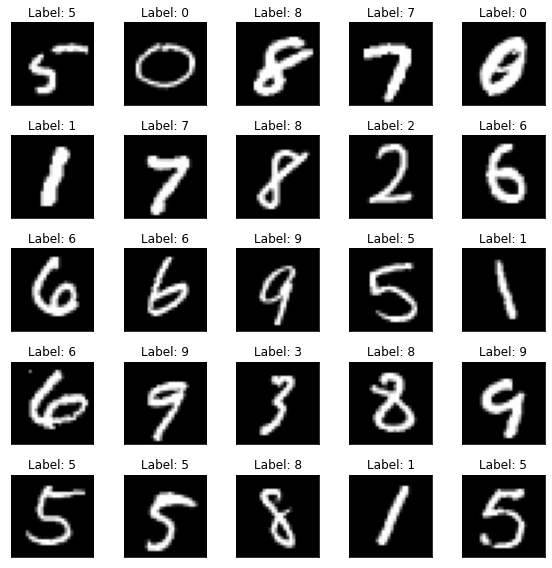

In [13]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Transform Dataloader

In [14]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [15]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

In [16]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)
    return km

# Experiment 1: MSE Loss with Embedding Dimension 4

In [17]:
from engine import Engine

In [18]:
torch.manual_seed(0)
engine = Engine(encoded_space_dim=4,num_epochs=config.NUM_EPOCHS)

In [19]:
encoder, decoder = engine.get_autoencoder()

## Some Examples

In [20]:
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


## 4. Train Model

In [21]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [22]:
loss_data = engine.train_model(train_loader,valid_loader, loss_fn, optim)


 EPOCH 1/50 	 train loss0.123 	 val loss 0.065

 EPOCH 6/50 	 train loss0.031 	 val loss 0.031

 EPOCH 11/50 	 train loss0.028 	 val loss 0.028

 EPOCH 16/50 	 train loss0.027 	 val loss 0.028

 EPOCH 21/50 	 train loss0.026 	 val loss 0.027

 EPOCH 26/50 	 train loss0.026 	 val loss 0.027

 EPOCH 31/50 	 train loss0.025 	 val loss 0.026

 EPOCH 36/50 	 train loss0.025 	 val loss 0.026

 EPOCH 41/50 	 train loss0.025 	 val loss 0.026

 EPOCH 46/50 	 train loss0.025 	 val loss 0.026


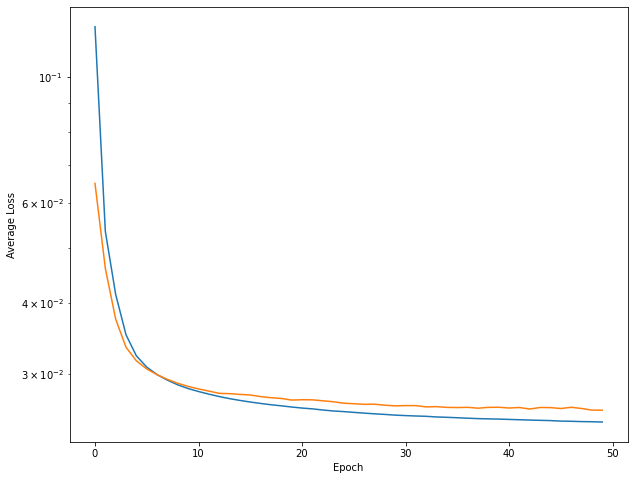

In [23]:
engine.plot_train_loss(loss_data)

## 5. Latent Space Exploration

In [24]:
import embedding_util as util

In [25]:
# Generate embeddings dataframe
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# encoder = torch.load('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/temp/best_decoder.pth')
encoder, decoer = engine.get_autoencoder()
embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)

100%|██████████| 10000/10000 [00:10<00:00, 924.78it/s]


In [26]:
embeddings_df

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-0.575358,1.093322,-1.458955,0.821042,7
1,-0.704205,1.081566,3.121421,0.390855,2
2,-1.193868,1.029505,0.389386,0.097219,1
3,0.069680,-0.833611,0.323108,-0.364470,0
4,-0.759269,-0.050171,-0.373126,-1.072212,4
...,...,...,...,...,...
9995,0.195060,-0.026170,2.194251,0.579825,2
9996,0.856279,0.264562,0.491010,0.479188,3
9997,-1.277563,0.213589,-0.405773,-0.490381,4
9998,-0.667561,-0.843061,0.012616,0.704743,5


In [27]:
embeddings_df.label

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: label, Length: 10000, dtype: int64

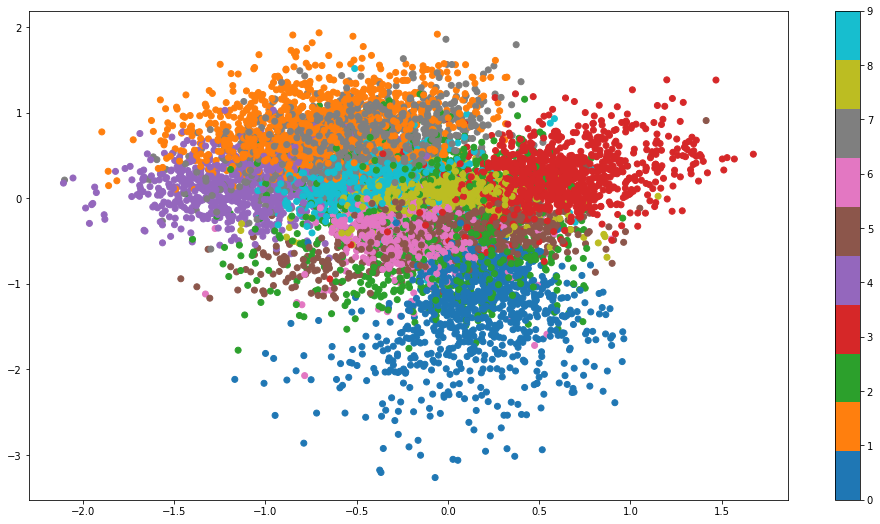

In [28]:
util.visualize_embeddings_2D(embeddings_df['Enc. Variable 0'], embeddings_df['Enc. Variable 1'], embeddings_df.label)

## Cluster Latent Space and visualize

In [29]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


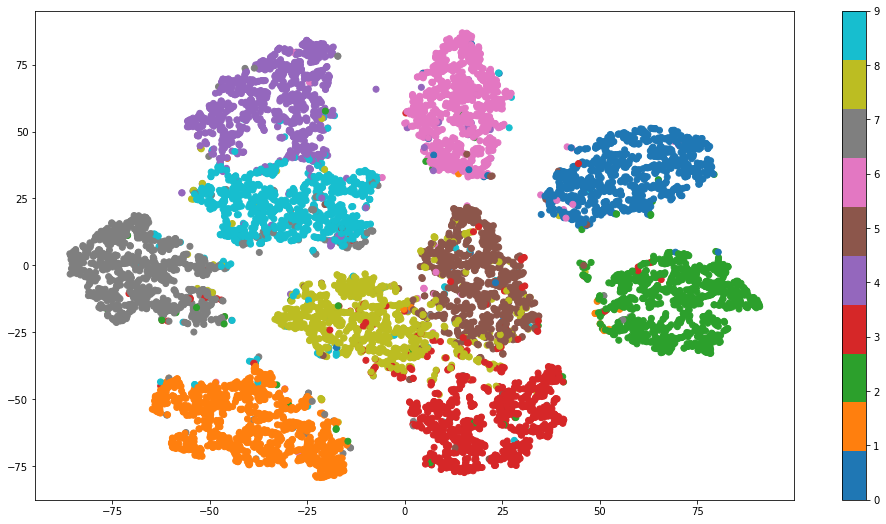

In [30]:
tsne = TSNE(n_components=2, init = 'pca')
clustering_results = util.cluster_latent_space(tsne, embeddings_df)

In [31]:
print(clustering_results)

[[-78.48773   -10.236983 ]
 [ 80.64694   -26.689034 ]
 [-43.578705  -69.80434  ]
 ...
 [-46.55893    55.516586 ]
 [ 15.0837755  16.86298  ]
 [ 24.574718   62.047783 ]]


In [32]:
dftsne = pd.DataFrame(clustering_results)
len(embeddings_df.label)
dftsne['cluster'] = embeddings_df.label

In [33]:
dftsne.head()

,0,1,cluster
0,-78.487732,-10.236983,7
1,80.646942,-26.689034,2
2,-43.578705,-69.804337,1
3,45.849953,28.871260,0
4,-22.945984,57.640442,4


In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)

In [35]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

In [36]:
fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 4", n_runs=5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.26 ± 0.02 s 
Homogeneity: 0.854 ± 0.000
Completeness: 0.854 ± 0.000
V-measure: 0.854 ± 0.000
Adjusted Rand-Index: 0.852 ± 0.000
Silhouette Coefficient: 0.534 ± 0.001


KMeans(n_clusters=10, random_state=4)

# Experiment 2: MSE Loss with Embedding Dimension 5

In [37]:
from engine import Engine

In [38]:
eng2 = Engine(5)

In [39]:
encoder, decoder = eng2.get_autoencoder()

In [40]:
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 5])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [41]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [42]:
loss_data = eng2.train_model(train_loader,valid_loader, loss_fn, optim)


 EPOCH 1/50 	 train loss0.136 	 val loss 0.063

 EPOCH 6/50 	 train loss0.034 	 val loss 0.034

 EPOCH 11/50 	 train loss0.029 	 val loss 0.028

 EPOCH 16/50 	 train loss0.025 	 val loss 0.025

 EPOCH 21/50 	 train loss0.023 	 val loss 0.024

 EPOCH 26/50 	 train loss0.022 	 val loss 0.023

 EPOCH 31/50 	 train loss0.022 	 val loss 0.023

 EPOCH 36/50 	 train loss0.022 	 val loss 0.022

 EPOCH 41/50 	 train loss0.021 	 val loss 0.022

 EPOCH 46/50 	 train loss0.021 	 val loss 0.022


In [43]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# encoder = torch.load('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/temp/best_decoder.pth')
encoder, decoer = eng2.get_autoencoder()
embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)

100%|██████████| 10000/10000 [00:10<00:00, 931.12it/s]


In [44]:
embeddings_df.head()

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,label
0,0.801414,-0.689177,0.203328,1.324396,1.581278,7
1,0.063938,0.358274,-0.886541,0.977156,-0.376107,2
2,-0.268653,1.001304,-0.659314,0.516480,1.112755,1
3,-0.230444,-0.535414,0.171011,-0.283627,-0.292084,0
4,0.347319,-1.298424,-0.509590,-0.960121,1.022249,4


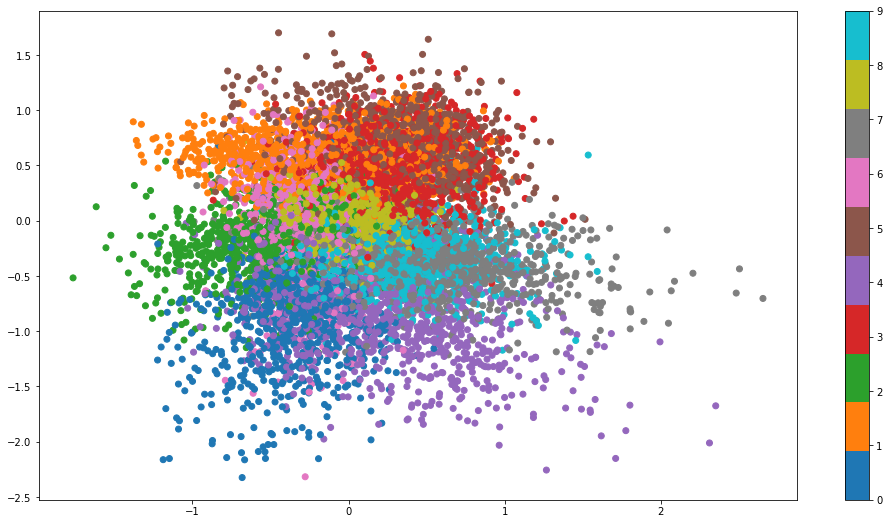

In [45]:
util.visualize_embeddings_2D(embeddings_df['Enc. Variable 0'], embeddings_df['Enc. Variable 1'], embeddings_df.label)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


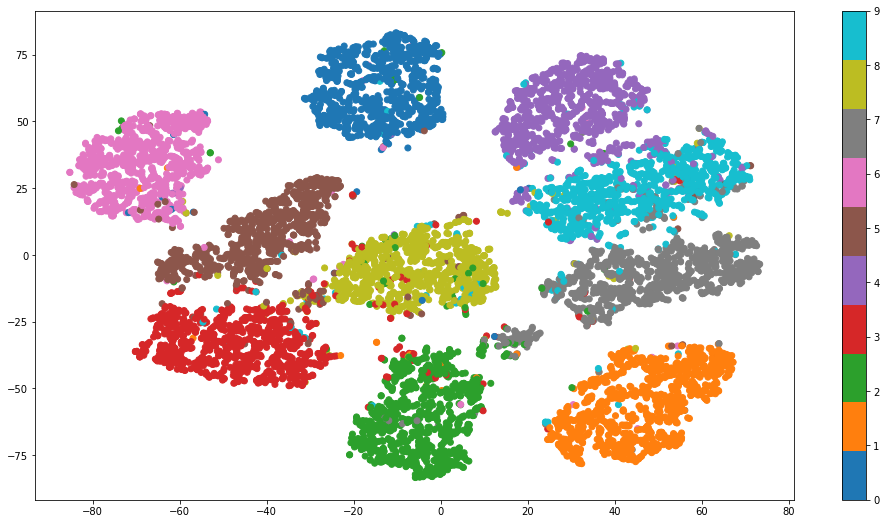

In [46]:
tsne = TSNE(n_components=2, init = 'pca')
clustering_results = util.cluster_latent_space(tsne, embeddings_df)

In [47]:
dftsne = pd.DataFrame(clustering_results)
len(embeddings_df.label)
dftsne['cluster'] = embeddings_df.label

In [48]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 5", n_runs=5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.24 ± 0.01 s 
Homogeneity: 0.857 ± 0.000
Completeness: 0.858 ± 0.000
V-measure: 0.858 ± 0.000
Adjusted Rand-Index: 0.851 ± 0.000
Silhouette Coefficient: 0.504 ± 0.005


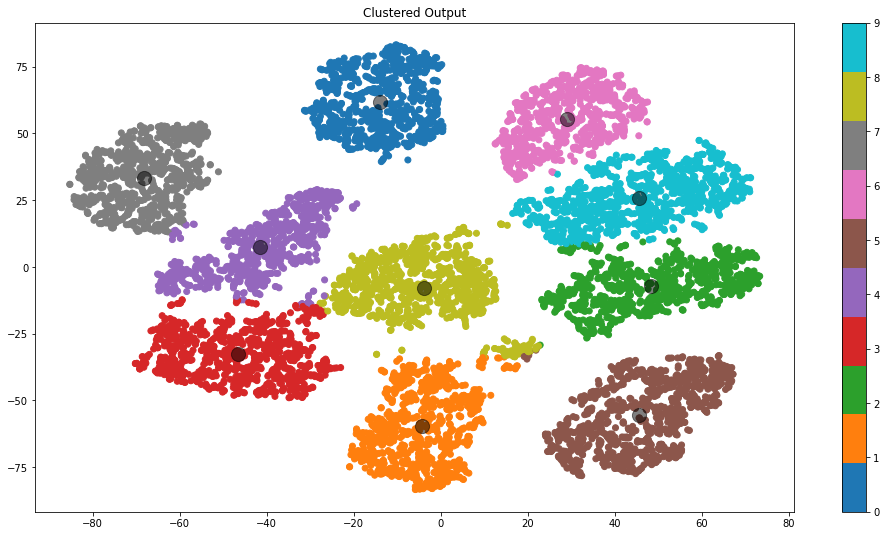

In [49]:
visualize_clustering_2D(dftsne[0],dftsne[1],kmeans.labels_,kmeans.cluster_centers_, "Clustered Output")

# Experiment 3: MSE Loss with Embedding Dimension 6

In [50]:
torch.manual_seed(0)
engine3 = Engine(encoded_space_dim=6,num_epochs=config.NUM_EPOCHS)

In [51]:
encoder, decoder = engine3.get_autoencoder()

In [52]:
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 6])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [53]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [54]:
loss_data = engine3.train_model(train_loader,valid_loader, loss_fn, optim)


 EPOCH 1/50 	 train loss0.134 	 val loss 0.077

 EPOCH 6/50 	 train loss0.025 	 val loss 0.024

 EPOCH 11/50 	 train loss0.022 	 val loss 0.022

 EPOCH 16/50 	 train loss0.021 	 val loss 0.021

 EPOCH 21/50 	 train loss0.020 	 val loss 0.021

 EPOCH 26/50 	 train loss0.020 	 val loss 0.020

 EPOCH 31/50 	 train loss0.019 	 val loss 0.020

 EPOCH 36/50 	 train loss0.019 	 val loss 0.020

 EPOCH 41/50 	 train loss0.019 	 val loss 0.020

 EPOCH 46/50 	 train loss0.019 	 val loss 0.020


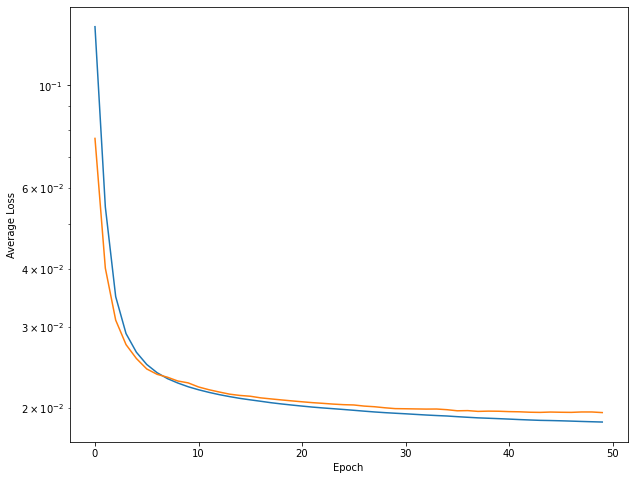

In [55]:
engine3.plot_train_loss(loss_data)

In [56]:
import embedding_util as util

In [57]:
# Generate embeddings dataframe
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# encoder = torch.load('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/temp/best_decoder.pth')
encoder, decoer = engine3.get_autoencoder()
embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)

100%|██████████| 10000/10000 [00:10<00:00, 931.90it/s]


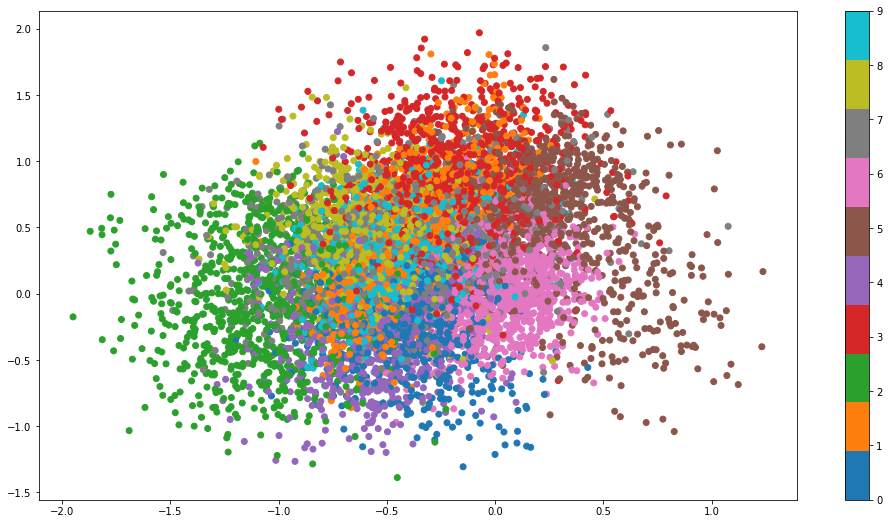

In [58]:
util.visualize_embeddings_2D(embeddings_df['Enc. Variable 0'], embeddings_df['Enc. Variable 1'], embeddings_df.label)

In [59]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


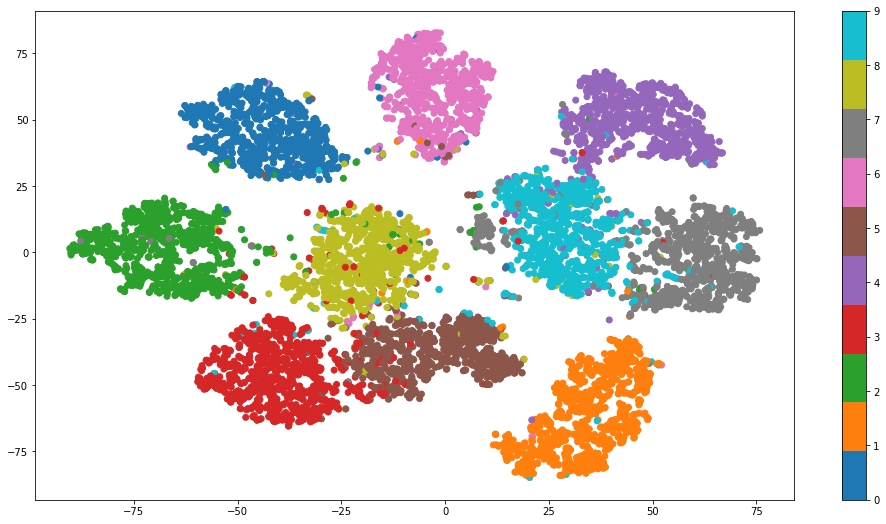

In [60]:
tsne_2 = TSNE(n_components=2, init = 'pca')
clustering_results = util.cluster_latent_space(tsne_2, embeddings_df)

In [61]:
dftsne = pd.DataFrame(clustering_results)
len(embeddings_df.label)
dftsne['cluster'] = embeddings_df.label

In [62]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)

In [63]:
kmeans = fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 6", n_runs=5)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.21 ± 0.02 s 
Homogeneity: 0.872 ± 0.000
Completeness: 0.872 ± 0.000
V-measure: 0.872 ± 0.000
Adjusted Rand-Index: 0.872 ± 0.000
Silhouette Coefficient: 0.528 ± 0.004


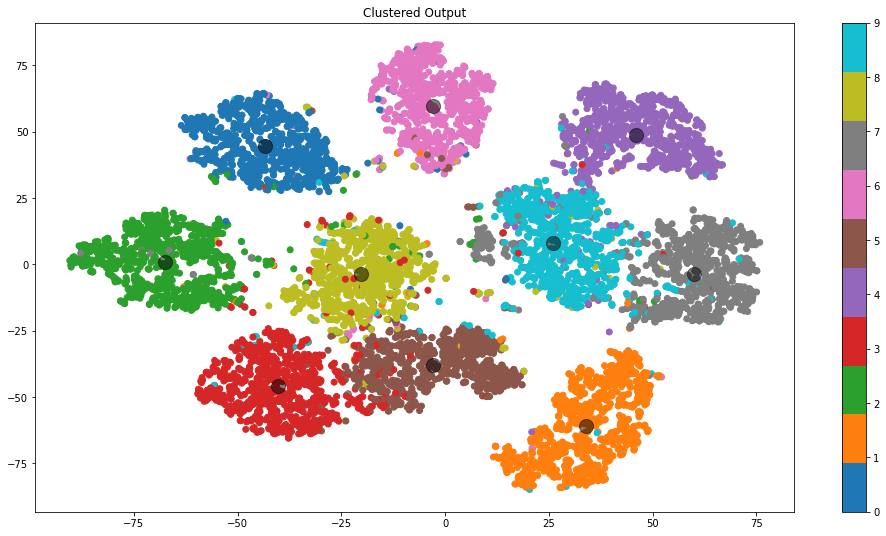

In [64]:
visualize_clustering_2D(dftsne[0],dftsne[1],embeddings_df.label,kmeans.cluster_centers_, "Clustered Output")

# Experiment 4: MSE Loss with Embedding Dimension 7

In [65]:
from engine import Engine

In [66]:
torch.manual_seed(0)
engine4 = Engine(encoded_space_dim=7,num_epochs=config.NUM_EPOCHS)

In [67]:
encoder, decoder = engine4.get_autoencoder()

In [68]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [69]:
# load the training and test datasets
train_data = datasets.MNIST(root=DATA_DIR, train=True,
                                   download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False,
                                  download=True)

In [70]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [71]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [72]:
loss_data = engine4.train_model(train_loader,valid_loader, loss_fn, optim)


 EPOCH 1/50 	 train loss0.043 	 val loss 0.027

 EPOCH 6/50 	 train loss0.020 	 val loss 0.022

 EPOCH 11/50 	 train loss0.019 	 val loss 0.021

 EPOCH 16/50 	 train loss0.018 	 val loss 0.020

 EPOCH 21/50 	 train loss0.018 	 val loss 0.020

 EPOCH 26/50 	 train loss0.018 	 val loss 0.020

 EPOCH 31/50 	 train loss0.018 	 val loss 0.020

 EPOCH 36/50 	 train loss0.018 	 val loss 0.019

 EPOCH 41/50 	 train loss0.018 	 val loss 0.019

 EPOCH 46/50 	 train loss0.018 	 val loss 0.019


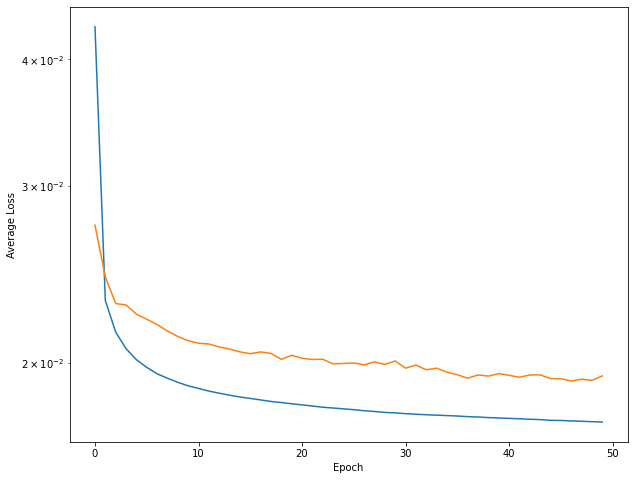

In [73]:
engine4.plot_train_loss(loss_data)

In [74]:
# Generate embeddings dataframe
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# encoder = torch.load('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/temp/best_decoder.pth')
encoder, decoer = engine4.get_autoencoder()
embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)

100%|██████████| 10000/10000 [00:10<00:00, 939.23it/s]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


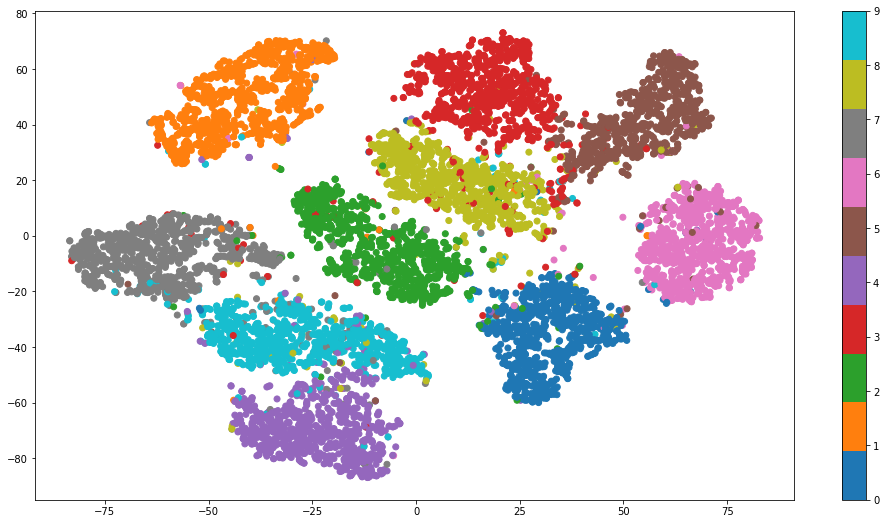

In [75]:
from sklearn.manifold import TSNE
tsne_3 = TSNE(n_components=2, init = 'pca')
clustering_results = util.cluster_latent_space(tsne_3, embeddings_df)

In [76]:
dftsne = pd.DataFrame(clustering_results)
len(embeddings_df.label)
dftsne['cluster'] = embeddings_df.label

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

clustering done in 0.25 ± 0.05 s 
Homogeneity: 0.865 ± 0.000
Completeness: 0.865 ± 0.000
V-measure: 0.865 ± 0.000
Adjusted Rand-Index: 0.866 ± 0.000
Silhouette Coefficient: 0.513 ± 0.006


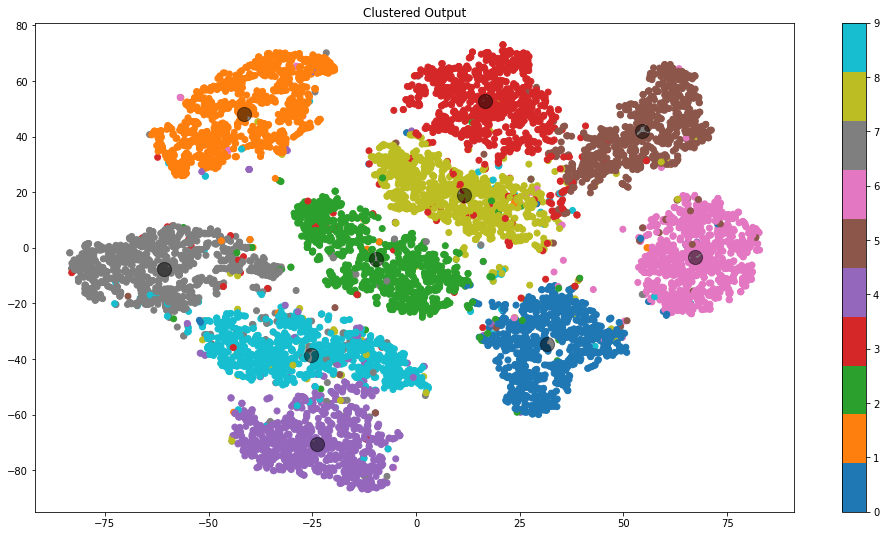

In [77]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans = fit_and_evaluate(kmeans, dftsne, dftsne['cluster'], name="KMeans with Embedding 7", n_runs=5)
visualize_clustering_2D(dftsne[0],dftsne[1],embeddings_df.label,kmeans.cluster_centers_, "Clustered Output")

# Evaluation of Clustering scores

In [78]:
evaluations

[{'estimator': 'KMeans with Embedding 4',
  'train_time': 0.2603760719299316,
  'Homogeneity': 0.8540435140787668,
  'Completeness': 0.854470443301129,
  'V-measure': 0.8542569253471821,
  'Adjusted Rand-Index': 0.8519156608726333,
  'Silhouette Coefficient': 0.5337237979490025},
 {'estimator': 'KMeans with Embedding 5',
  'train_time': 0.23826050758361816,
  'Homogeneity': 0.8570647070314387,
  'Completeness': 0.858082944786536,
  'V-measure': 0.8575735235439961,
  'Adjusted Rand-Index': 0.8513518969442859,
  'Silhouette Coefficient': 0.503527989478965},
 {'estimator': 'KMeans with Embedding 6',
  'train_time': 0.21152329444885254,
  'Homogeneity': 0.8718974977246944,
  'Completeness': 0.872131154710764,
  'V-measure': 0.8720143105655819,
  'Adjusted Rand-Index': 0.8722447002639873,
  'Silhouette Coefficient': 0.5282673485626994},
 {'estimator': 'KMeans with Embedding 7',
  'train_time': 0.2473605155944824,
  'Homogeneity': 0.8646542568291145,
  'Completeness': 0.8653021909909704,
  '

In [79]:
len(evaluations_std)

4

In [80]:
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")

In [81]:
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

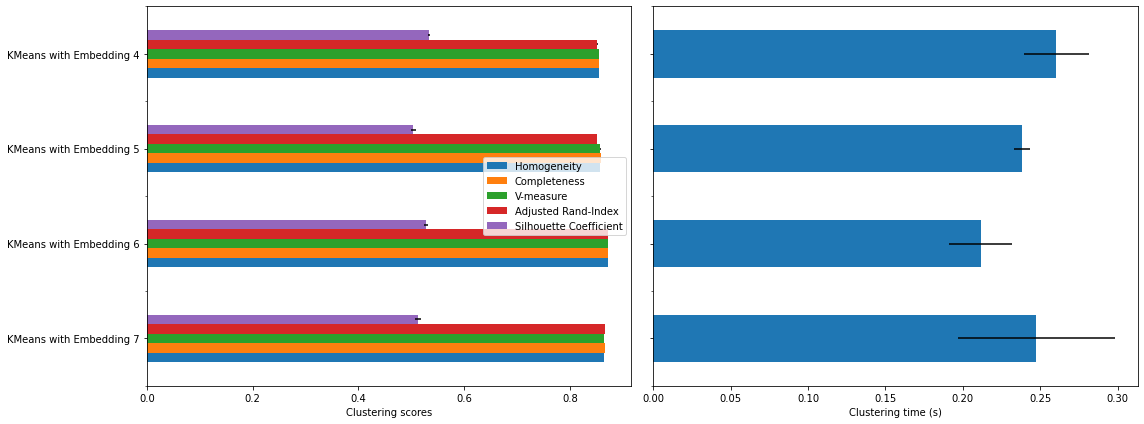

In [83]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
